In [1]:
from pathlib import Path
import urllib.request

import requests
import bs4
import pandas as pd

In [2]:
REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

# Obtain UniprotIDs for all human kinases

There are several sources that can be used to identify the human kinome in Uniprot:

* [KinHub](http://kinhub.org/kinases.html)
* [KLIFS](https://klifs.vu-compmedchem.nl/)
* [UniProt](https://www.uniprot.org/docs/pkinfam.txt)'s _Human and mouse protein kinases: classification and index_.
* Scientific literature

There are also several nomenclatures commonly used to refer to kinases: xName, Manning, HGNC... For  completeness, we will try to merge all these sources into a single table we can use in later exercises.

## 01. KinHub

This part is straightforward: it retrieves the table listed at [Kinhub.org](http://kinhub.org/kinases.html) with `requests` and `beautifulsoup`.

In [3]:
r = requests.get("http://kinhub.org/kinases.html")
r.raise_for_status()
html = bs4.BeautifulSoup(r.text)

In [4]:
table = html.find('table')
columns = [cell.text.strip() for cell in table.find('thead').find_all('th')]
records = [[cell.text.strip() for cell in row.find_all('td')] for row in table.find('tbody').find_all('tr')]
kinhub = pd.DataFrame.from_records(records, columns=columns).sort_values(by="xName")
kinhub

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
336,AAK1,AAK1,AAK1,AP2-associated protein kinase 1,Other,NAK,,Q2M2I8
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
24,ABL2,ARG,ABL2,Abelson tyrosine-protein kinase 2,TK,Abl,,P42684
529,ABR,ABR,ABR,Active breakpoint cluster region-related protein,Atypical,BCR,,Q12979
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
...,...,...,...,...,...,...,...,...
274,p38g,p38g,MAPK12,Mitogen-activated protein kinase 12,CMGC,MAPK,p38,P53778
209,p70S6K,p70S6K,RPS6KB1,Ribosomal protein S6 kinase beta-1,AGC,RSK,RSKp70,P23443
210,p70S6Kb,p70S6Kb,RPS6KB2,Ribosomal protein S6 kinase beta-2,AGC,RSK,RSKp70,Q9UBS0
477,skMLCK,skMLCK,MYLK2,Myosin light chain kinase 2,CAMK,MLCK,,Q9H1R3


## 02 KLIFS

In [5]:
r = requests.get("https://klifs.vu-compmedchem.nl/api/kinase_names?species=HUMAN")
r.raise_for_status()
data = r.json()
all_ids = [record["kinase_ID"] for record in data]

In [6]:
r = requests.get(f"https://klifs.vu-compmedchem.nl/api/kinase_information?kinase_ID={','.join(map(str, all_ids))}")
r.raise_for_status()
data = r.json()

In [7]:
items = []
for record in data:
    items.append({
        "KLIFS Name": record["name"],
        "HGNC Name": record["HGNC"],
        "Family": record["family"],
        "Group": record["group"],
        "Class": record["kinase_class"],
        "Kinase Name": record["full_name"],
        "UniprotID": record["uniprot"],
        "IUPHAR": record["iuphar"],
        "Pocket": record["pocket"],
        "KLIFS ID": record["kinase_ID"]
    })
klifs = pd.DataFrame.from_dict(items).sort_values(by="KLIFS Name")
klifs

,KLIFS Name,HGNC Name,Family,Group,Class,Kinase Name,UniprotID,IUPHAR,Pocket,KLIFS ID
276,AAK1,AAK1,NAK,Other,BIKE,AP2 associated kinase 1,Q2M2I8,1921,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,277
391,ABL1,ABL1,Abl,TK,,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,1923,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,392
392,ABL2,ABL2,Abl,TK,,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1924,HKLGGGQYGEVYVVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIVTE...,393
393,ACK,TNK2,Ack,TK,,"tyrosine kinase, non-receptor, 2",Q07912,2246,EKLGDGSFGVVRRVAVKCLDFIREVNAMHSLDRNLIRLYGVKMVTE...,394
522,ACTR2,ACVR2A,STKR,TKL,Type2,activin A receptor type IIA,P27037,1791,EVKARGRFGCVWKVAVKIFSWQNEYEVYSLPGENILQFIGAWLITA...,523
...,...,...,...,...,...,...,...,...,...,...
251,p38g,MAPK12,MAPK,CMGC,p38,mitogen-activated protein kinase 12,P53778,1501,QPVGSGAYGAVCSVAIKKLRAYRELRLLKHMRENVIGLLDVYLVMP...,252
50,p70S6K,RPS6KB1,RSK,AGC,p70,ribosomal protein S6 kinase B1,P23443,1525,RVLGKGGYGKVFQFAMKVLHTKAERNILEEVKPFIVDLIYAYLILE...,51
51,p70S6Kb,RPS6KB2,RSK,AGC,p70,ribosomal protein S6 kinase B2,Q9UBS0,1526,RVLGKGGYGKVFQYAMKVLHTRAERNILESVKPFIVELAYAYLILE...,52
154,skMLCK,MYLK2,MLCK,CAMK,,myosin light chain kinase 2,Q9H1R3,1553,EALGGGKFGAVCTLAAKVIMVLLEIEVMNQLNRNLIQLYAAVLFME...,155


## 03 Pkinfam

UniProt maintains [a txt file](https://www.uniprot.org/docs/pkinfam.txt) with a kinase index: `pkinfam`. We can try to parse it and see what information we have there.

In [8]:
r = requests.get("https://www.uniprot.org/docs/pkinfam.txt")
r.raise_for_status()
text = r.text

In [9]:
items = []
current_category = None
lines = iter(text.splitlines())
for line in lines:
    if line.startswith("==="):  # this is a header
        line = next(lines)
        current_category = line.strip()
        next(lines)
        next(lines)
        continue
    if not line.strip() or not current_category or '_HUMAN' not in line:
        continue
    if line.startswith("---") and current_category:
        break
    
    fields = line.split()
    name = fields[0]
    uniprot_id = fields[2].replace("(", "").replace(")", "")
    items.append({
        'Name': name,
        'Family': current_category,
        'UniprotID': uniprot_id,
    })
pkinfam = pd.DataFrame.from_dict(items).sort_values(by="Name")
pkinfam

,Name,Family,UniprotID
403,AAK1,Other,Q2M2I8
313,AATK,Tyr protein kinase family,Q6ZMQ8
314,ABL1,Tyr protein kinase family,P00519
315,ABL2,Tyr protein kinase family,P42684
279,ACVR1,TKL Ser/Thr protein kinase family,Q04771
...,...,...,...
481,WNK2,Other,Q9Y3S1
482,WNK3,Other,Q9BYP7
483,WNK4,Other,Q96J92
401,YES1,Tyr protein kinase family,P07947


## 04 Dunbrack structurally validated kinase alignment

Dataset extracted from:

> Modi, V., Dunbrack, R.L. A Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Sci Rep 9, 19790 (2019). https://doi.org/10.1038/s41598-019-56499-4

In [10]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-56499-4/MediaObjects/41598_2019_56499_MOESM4_ESM.txt"
dunbrack = pd.read_csv(url, sep=r"\s+")
dunbrack

,1_Group,2_Gene,3_HGNC,4_Uni_entry,5_Uni_acc,6_Domain_begin,7_Domain_end,8_Domain_length,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn
0,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,259,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC"
1,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,258,9,3E8DB,DFGin,BLAminus,AGC,AGC,NaN
2,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,258,9,NaN,NaN,NaN,AGC,AGC,PKBG
3,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,267,14,NaN,NaN,NaN,AGC,AGC,KIAA0451
4,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,267,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,TYR,TYK2_1,HGNC:12440,TYK2_HUMAN,P29597,589,868,280,26,3ZONA,DFGin,NaN,TYR,TYR,NaN
493,TYR,TYK2_2,HGNC:12440,TYK2_HUMAN,P29597,897,1171,275,21,4GVJA,DFGin,BLAminus,TYR,TYR,NaN
494,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,271,10,NaN,NaN,NaN,TYR,TYR,"BYK,DTK,RSE,SKY,TIF"
495,TYR,YES1,HGNC:12841,YES_HUMAN,P07947,277,528,252,10,NaN,NaN,NaN,TYR,TYR,YES


In [11]:
dunbrack["5_Uni_acc"].unique().shape

(484,)

## 05 Dunbrack's `kincore` webserver

The [Kinase Conformation Resource](http://dunbrack3.fccc.edu/kincore/) (`kincore`) is the accompanying website for 2019's kinase-focused works by Modi and Dunbrack:

> Defining a new nomenclature for the structures of active and inactive kinases. Vivek Modi and Roland L. Dunbrack, PNAS 2019, 116(14) 6818-6827.
> Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Vivek Modi and Roland L. Dunbrack, Sci Rep 2019, 9, 19790.

All kinases thereby listed are programmably accessible via a TSV file in this url:

```
http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tsv
```

In [12]:
url = "http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tsv"
kincore = pd.read_csv(url, sep="\t")
kincore

,Organism,Group,Gene,UniprotID,PDB,Method,Resolution,Rfac,FreeRfac,SpatialLabel,DihedralLabel,C-helix,Ligand,LigandType,DFG_Phe,Edia_X_O,Edia_Asp_O,Edia_Phe_O,Edia_Gly_O,ProteinName
0,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZB,XRAY,2.12,0.19,0.24,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.85,0.88,0.94,0.91,RAC-alpha serine/threonine-protein kinase
1,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZA,XRAY,2.12,0.19,0.24,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.88,0.92,0.93,1.04,RAC-alpha serine/threonine-protein kinase
2,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUB,XRAY,2.40,0.18,0.23,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.92,0.78,0.99,0.86,RAC-alpha serine/threonine-protein kinase
3,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUA,XRAY,2.40,0.18,0.23,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.92,0.81,1.00,0.87,RAC-alpha serine/threonine-protein kinase
4,Homo sapiens,AGC,AKT1,AKT1_HUMAN,3QKMA,XRAY,2.20,0.19,0.25,DFGin,BLAminus,in,SM9,Type1,293,1.07,0.98,0.94,1.00,RAC-alpha serine/threonine-protein kinase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,5TKDA,XRAY,1.92,0.19,0.21,DFGin,None,in,7GL,Type1,760,1.12,1.10,1.10,1.05,Non-receptor tyrosine-protein kinase TYK2
6572,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,3ZONA,XRAY,2.15,0.22,0.27,DFGin,None,in,IK1,Type1,760,0.97,0.99,0.96,0.95,Non-receptor tyrosine-protein kinase TYK2
6573,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,1U59A,XRAY,2.30,0.22,0.27,DFGin,BLAminus,in,STU,Type1,480,0.85,0.87,1.00,0.81,Tyrosine-protein kinase ZAP-70
6574,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,4K2RA,XRAY,3.00,0.21,0.29,DFGin,BLAplus,out,ANP,Type1,480,0.72,0.62,0.44,0.59,Tyrosine-protein kinase ZAP-70


Unfortunately, this database only contains kinases for which structural data is available, so the number of unique UniprotIDs is smaller, so we won't export it.

In [13]:
kincore["UniprotID"].unique().shape

(273,)

## 06 KinBase

Kinase.com provides a `kinbase` dataset in form of Fasta sequences. However, it doesn't provide identifiers such as UniprotIDs.

In [14]:
r = requests.get("http://kinase.com/kinbase/FastaFiles/Human_kinase_protein.fasta")
r.raise_for_status()

In [15]:
header = ["Gene", "Comment", "Sequence"]
records = []
for line in r.text.splitlines():
    line = line.strip()
    if not line:
        continue
    if line.startswith(">"):
        name, comment = line.split(None, 1)
        records.append({"Gene": name[1:], "Comment": comment, "sequence": ""})
    else:
        records[-1]["sequence"] += line
kinbase = pd.DataFrame.from_dict(records)
kinbase

,Gene,Comment,sequence
0,TTBK2_Hsap,(CK1/TTBK),MSGGGEQLDILSVGILVKERWKVLRKIGGGGFGEIYDALDMLTREN...
1,TTBK1_Hsap,(CK1/TTBK),MQCLAAALKDETNMSGGGEQADILPANYVVKDRWKVLKKIGGGGFG...
2,TSSK4_Hsap,(CAMK/TSSK),MGKGDVLEAAPTTTAYHSLMDEYGYEVGKAIGHGSYGSVYEAFYTK...
3,TSSK3_Hsap,(CAMK/TSSK),MEDFLLSNGYQLGKTIGEGTYSKVKEAFSKKHQRKVAIKVIDKMGG...
4,TSSK2_Hsap,(CAMK/TSSK),MDDATVLRKKGYIVGINLGKGSYAKVKSAYSERLKFNVAVKIIDRK...
...,...,...,...
511,ZAK_Hsap,(TKL/MLK/ZAK),MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...
512,ZAP70_Hsap,(TK/Syk),MPDPAAHLPFFYGSISRAEAEEHLKLAGMADGLFLLRQCLRSLGGY...
513,DCLK3_Hsap,(CAMK/DCAMKL),MGKEPLTLKSIQVAVEELYPNKARALTLAQHSRAPSPRLRSRLFSK...
514,DCLK2_Hsap,(CAMK/DCAMKL),MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIP...


However, in their new website, they do provide more information in an Excel spreadsheet:

In [16]:
kinbasex = pd.read_excel("http://kinase.com/static/colt/data/human/kinome/tables/Kincat_Hsap.08.02.xls")
kinbasex

,Name,SK,Group,Family,Subfamily,Pseudogene?,Header,cDNA,Protein,Kinase Domain,...,Entrez_Synonyms,Entrez_dbXrefs,Entrez_Chromosome,Entrez_map_location,Entrez_description,Entrez_gene_type,Entrez_symbol_from_nomenclature_authority,Entrez_full_name_from_NA,Entrez_Nomenclature_status (O=official; I=intermediate_,Entrez_other_designations
0,AKT1,SK018,AGC,Akt,NaN,N,AGC_AKT__SK018_AKT1,CGGCAGGACCGAGCGCGGCAGGCGGCTGGCCCAGCGCACGCAGCGC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,FEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHT...,...,AKT|MGC99656|PKB|PRKBA|RAC|RAC-ALPHA,HGNC:391|MIM:164730|HPRD:01261,14,14q32.32|14q32.32,v-akt murine thymoma viral oncogene homolog 1,protein-coding,AKT1,v-akt murine thymoma viral oncogene homolog 1,O,RAC-alpha serine/threonine-protein kinase|muri...
1,AKT2,SK019,AGC,Akt,NaN,N,AGC_AKT__SK019_AKT2,AGCGGGGGCTGGGGGGAGGGGGCGGGGGGGGCCGCGCCGTGCTAGC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,FDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHT...,...,PKBBETA|PRKBB|RAC-BETA,HGNC:392|MIM:164731|HPRD:01262,19,19q13.1-q13.2,v-akt murine thymoma viral oncogene homolog 2,protein-coding,AKT2,v-akt murine thymoma viral oncogene homolog 2,O,Murine thymoma viral (v-akt) homolog-2|rac pro...
2,AKT3,SK020,AGC,Akt,NaN,N,AGC_AKT__SK020_AKT3,AGGGGAGTCATCATGAGCGATGTTACCATTGTGAAAGAAGGTTGGG...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,FDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHT...,...,DKFZP434N0250|PKBG|PRKBG|RAC-PK-gamma|RAC-gamm...,HGNC:393|HPRD:06441,1,1q43-q44,v-akt murine thymoma viral oncogene homolog 3 ...,protein-coding,AKT3,v-akt murine thymoma viral oncogene homolog 3 ...,O,RAC-gamma serine/threonine protein kinase|prot...
3,CRIK,SK695,AGC,DMPK,CRIK,N,AGC_DMPK__SK695_CRIK,GGGCGGAACAGATCGCAGACCTGGGGGTTCGCAGAGCCGCCAGTGG...,MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPL...,FEVRSLVGCGHFAEVQVVREKATGDIYAMKVMKKKALLAQEQVSFF...,...,CRIK|KIAA0949|STK21,HGNC:1985|MIM:605629|HPRD:09289,12,12q24,"citron (rho-interacting, serine/threonine kina...",protein-coding,CIT,"citron (rho-interacting, serine/threonine kina...",O,"citron|rho-interacting, serine/threonine kinas..."
4,DMPK1,SK111,AGC,DMPK,GEK,N,AGC_DMPK_GEK_SK111_DMPK1,GCCACAAGCCTCCACCCCAGCTGGTCCCCCACCCAGGCTGCCCAGT...,MGGHFWPPEPYTVFMWGSPWEADSPRVKLRGREKGRQTEGGAFPLV...,FEILKVIGRGAFSEVAVVKMKQTGQVYAMKIMNKWDMLKRGEVSCF...,...,DM|DM1|DM1PK|DMK,HGNC:2933|MIM:605377|HPRD:05645,19,19q13.3,dystrophia myotonica-protein kinase,protein-coding,DMPK,dystrophia myotonica-protein kinase,O,dystrophia myotonica 1|myotonic dystrophy prot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,RAF1ps,SK325,TKL,RAF,RAF,Y,TKL_RAF__SK325_RAF1ps,GCCTTGGAGTTTTATGGCTCTAGCTACATCTGCCTTACAATTGTTC...,MGEELQVDFLSHVPLTTHNFAQKTLLKFTFCNXXKFLLSGFQHHAR...,RLSGRGNAVKILQGCQPDXPEQFQAFRDEVAVLSSVGHVDILLLLG...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,BRAFps,SK673,TKL,RAF,RAF,Y,TKL_RAF__SK673_BRAFps,ATGAGAGGTCTAATCCCAGAGTGCGGTGCTGTTTACAGAATTCAGG...,MRGLIPECGAVYRIQDGEKKTIDQDTGVSWLTGEELHVEVLENVPL...,ITVGQRIGSGSFGTVYKGKWHGVVAVKMLNVAAPTPHQVEAFKMKE...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617,ARAFps,SK567,TKL,RAF,RAF,Y,TKL_RAF__SK567_ARAFps,ATAGTCCAGCTAATTGACATGGCCCAGCAGACTGCCCAGGGCATGA...,IVQLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIFQHKMSDSRLATV...,QLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,BMPR1Aps2,SK739,TKL,STKR,Type1,Y,TKL_STKR_Type1_SK739_BMPR1Aps2,ACATTATTGCAAGAGCATCTCAAGCAGACGTCGTTACAATCGTGAT...,HYCKSISSRRRYNRDLEXDEAFIPVGESLKDLIDQSQSSGSGSGLP...,IQMVRQVGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All Entrez-validated protein coding kinase genes:

In [17]:
kinbasex[kinbasex["Entrez_gene_type"] == "protein-coding"]["Name"].unique().shape

(514,)

## 07 All UniProt

Searching UniProt for all [human proteins with confirmed kinase activity](https://www.uniprot.org/uniprot/?query=keyword%3A%22Kinase+%5BKW-0418%5D%22+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score) shows 636 entries (queried on 2020.06.22). Programmatically, we can use the URL API for now.

[Details on URL queries](https://www.uniprot.org/help/uniprotkb_column_names)

In [18]:
from urllib.parse import quote
url = ("https://www.uniprot.org/uniprot/?query="
       #"keyword:%22Kinase%20[KW-0418]%22%20organism:%22Homo%20sapiens%20(Human)%20[9606]%22"
       + quote(r'(keyword:"Kinase [KW-0418]" OR goa:("kinase activity [0016301]") OR goa:("protein kinase activity [0004672]")) AND organism:"Homo sapiens (Human) [9606]"') +
       "&format=tab&force=true&columns=id,entry%20name,reviewed,protein%20names,genes&sort=name")
uniprot = pd.read_csv(url, sep="\t").rename(columns={"Entry": "UniprotID"})
reviewed_uniprot = uniprot[uniprot.Status=="reviewed"].drop("Status", axis=1)

In [19]:
reviewed_uniprot

,UniprotID,Entry name,Protein names,Gene names
1,O75191,XYLB_HUMAN,Xylulose kinase (Xylulokinase) (EC 2.7.1.17),XYLB
9,P0C1S8,WEE2_HUMAN,Wee1-like protein kinase 2 (EC 2.7.10.2) (Wee1...,WEE2 WEE1B
13,P30291,WEE1_HUMAN,Wee1-like protein kinase (WEE1hu) (EC 2.7.10.2...,WEE1
25,P01185,NEU2_HUMAN,Vasopressin-neurophysin 2-copeptin (AVP-NPII) ...,AVP ARVP VP
40,P35916,VGFR3_HUMAN,Vascular endothelial growth factor receptor 3 ...,FLT4 VEGFR3
...,...,...,...,...
4347,Q00013,EM55_HUMAN,55 kDa erythrocyte membrane protein (p55) (Mem...,MPP1 DXS552E EMP55
4356,O15530,PDPK1_HUMAN,3-phosphoinositide-dependent protein kinase 1 ...,PDPK1 PDK1
4360,O14874,BCKD_HUMAN,[3-methyl-2-oxobutanoate dehydrogenase [lipoam...,BCKDK
4361,Q05823,RN5A_HUMAN,2-5A-dependent ribonuclease (2-5A-dependent RN...,RNASEL RNS4


# Review results so far

KinHub lists 536 kinases, KLIFS 555, PkinFam 513, and a GO-based query on UniprotKB produces 741 rows. Let's compare the listed Uniprot IDs.

In [24]:
datasets = {
    "kinhub": kinhub,
    "klifs": klifs,
    "pkinfam": pkinfam,
    "reviewed_uniprot": reviewed_uniprot,
    "dunbrack": dunbrack.rename(columns={"5_Uni_acc": "UniprotID"})
}
uniprot_ids = {}
for label, df in datasets.items():
    original = df.UniprotID.tolist()
    subset = set(original)
    uniprot_ids[label] = subset
    diff = len(original) - len(subset)
    if diff:
        print(label, "has", diff, "duplicates")

kinhub has 14 duplicates
klifs has 13 duplicates
dunbrack has 13 duplicates


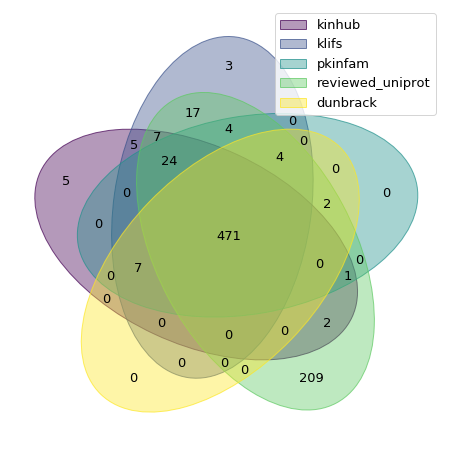

In [25]:
from venn import venn
venn(uniprot_ids);

So, how come UniProt is missing that many kinases (outside yellow)? It _should_ be the authoritative resource, right? Let's see.

In [26]:
for name, ds in uniprot_ids.items():
    if name == "dunbrack":
        continue
    print("Is Dunbrack's a subset of", name, "?", uniprot_ids["dunbrack"].issubset(ds))

Is Dunbrack's a subset of kinhub ? False
Is Dunbrack's a subset of klifs ? False
Is Dunbrack's a subset of pkinfam ? True
Is Dunbrack's a subset of reviewed_uniprot ? False


In [27]:
only_pkinfam = uniprot_ids["pkinfam"].difference(uniprot_ids["kinhub"] | uniprot_ids["klifs"] | uniprot_ids["reviewed_uniprot"])
print("Only in pkinfam:", len(only_pkinfam))
for identifier in only_pkinfam:
    print(" ", identifier, "->", *pkinfam[pkinfam.UniprotID == identifier].Name)

print()
only_kinhub = uniprot_ids["kinhub"].difference(uniprot_ids["pkinfam"] | uniprot_ids["klifs"] | uniprot_ids["reviewed_uniprot"])
print("Only in KinHub:", len(only_kinhub))
for identifier in only_kinhub:
    print(" ", identifier, "->", *kinhub[kinhub.UniprotID == identifier].xName)

print()
only_klifs = uniprot_ids["klifs"].difference(uniprot_ids["pkinfam"] | uniprot_ids["kinhub"] | uniprot_ids["reviewed_uniprot"])
print("Only in KLIFS:", len(only_klifs))
for identifier in only_klifs:
    print(" ", identifier, "->", *klifs[klifs.UniprotID == identifier]["HGNC Name"])
    
print()
not_uniprot = (uniprot_ids["pkinfam"] | uniprot_ids["kinhub"] | uniprot_ids["klifs"]).difference(uniprot_ids["reviewed_uniprot"])
print("In total, not in uniprot:", len(not_uniprot))
for identifier in not_uniprot:
    print(" ", identifier)

Only in pkinfam: 0

Only in KinHub: 5
  Q6IBK5 -> GTF2F1
  Q12979 -> ABR
  B5MCJ9 -> TIF1D
  Q9NRL2 -> BAZ1A
  P53004 -> BLVRA

Only in KLIFS: 3
  O43921 -> EFNA2
  Q9UJY1 -> HSPB8
  Q9H6X2 -> ANTXR1

In total, not in uniprot: 20
  O43921
  Q6IBK5
  Q7Z7A4
  Q15059
  Q92519
  Q96RU8
  Q9UJY1
  Q9UHY1
  Q58F21
  P53004
  Q8NB16
  P25440
  Q8IZE3
  Q96RU7
  Q12979
  Q9UPN9
  Q9H6X2
  Q9NRL2
  B5MCJ9
  Q9Y4A5


What are these 20 kinases that are not considered to have a kinase activity, *but* other datasets have included? We can check the GO annotations:

In [42]:
for i, entry in enumerate(not_uniprot, 1):
    r = requests.get(fr"https://www.uniprot.org/uniprot/{entry}.txt")
    r.raise_for_status()
    print(i, entry)
    for line in r.text.splitlines():
        if line.startswith(("ID", "DE")):
            print(line)
        elif line.startswith("DR   GO;") and "; F:" in line:
            print(line)
    print()

1 B5MCJ9
ID   B5MCJ9_HUMAN            Unreviewed;      1245 AA.
DE   SubName: Full=Tripartite motif-containing protein 66 {ECO:0000313|Ensembl:ENSP00000384876};
DR   GO; GO:0008270; F:zinc ion binding; IEA:InterPro.

2 Q9UPN9
ID   TRI33_HUMAN             Reviewed;        1127 AA.
DE   RecName: Full=E3 ubiquitin-protein ligase TRIM33;
DE            EC=2.3.2.27;
DE   AltName: Full=Ectodermin homolog;
DE   AltName: Full=RET-fused gene 7 protein;
DE            Short=Protein Rfg7;
DE   AltName: Full=RING-type E3 ubiquitin transferase TRIM33 {ECO:0000305};
DE   AltName: Full=Transcription intermediary factor 1-gamma;
DE            Short=TIF1-gamma;
DE   AltName: Full=Tripartite motif-containing protein 33;
DR   GO; GO:0070410; F:co-SMAD binding; IPI:BHF-UCL.
DR   GO; GO:0003677; F:DNA binding; IEA:UniProtKB-KW.
DR   GO; GO:0070412; F:R-SMAD binding; IPI:BHF-UCL.
DR   GO; GO:0004842; F:ubiquitin-protein transferase activity; TAS:Reactome.
DR   GO; GO:0008270; F:zinc ion binding; IEA:InterPro.

Since there'no agreement to what a kinase *is*, we will output everything already considered by the three curated listings:

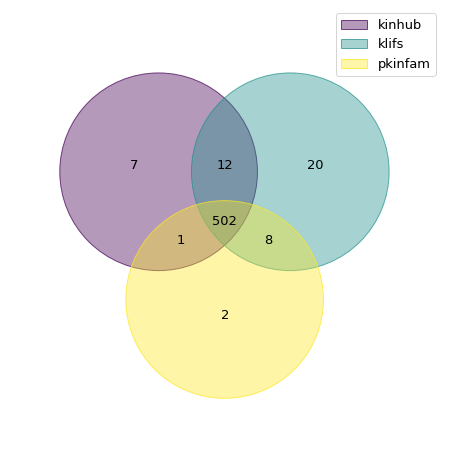

In [29]:
aggregated = {
"kinhub" : uniprot_ids["kinhub"],
"klifs" : uniprot_ids["klifs"],
"pkinfam" : uniprot_ids["pkinfam"],
}
venn(aggregated);

Let's build the final dataframe with all kinases:

In [68]:
kinases = pd.concat(
    [
        kinhub[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(kinhub=1), 
        klifs[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(klifs=1), 
        pkinfam[["Name", "UniprotID"]].assign(pkinfam=1), 
    ]
)
kinases

/home/jaime/.conda/envs/kinoml/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,Name,UniprotID,kinhub,klifs,pkinfam
336,AAK1,Q2M2I8,1.0,NaN,NaN
0,ABL1,P00519,1.0,NaN,NaN
24,ABL2,P42684,1.0,NaN,NaN
529,ABR,Q12979,1.0,NaN,NaN
1,TNK2,Q07912,1.0,NaN,NaN
...,...,...,...,...,...
481,WNK2,Q9Y3S1,NaN,NaN,1.0
482,WNK3,Q9BYP7,NaN,NaN,1.0
483,WNK4,Q96J92,NaN,NaN,1.0
401,YES1,P07947,NaN,NaN,1.0


In [69]:
kinases.drop_duplicates(subset=["UniprotID"])

,Name,UniprotID,kinhub,klifs,pkinfam
336,AAK1,Q2M2I8,1.0,NaN,NaN
0,ABL1,P00519,1.0,NaN,NaN
24,ABL2,P42684,1.0,NaN,NaN
529,ABR,Q12979,1.0,NaN,NaN
1,TNK2,Q07912,1.0,NaN,NaN
...,...,...,...,...,...
528,PIK3CB,P42338,NaN,1.0,NaN
530,PIK3CD,O00329,NaN,1.0,NaN
529,PIK3CG,P48736,NaN,1.0,NaN
435,PEAK3,Q6ZS72,NaN,NaN,1.0


In [103]:
grouped = kinases.groupby(["UniprotID", "Name"]).agg('sum').apply({'kinhub': bool, 'klifs':bool, 'pkinfam':bool})
grouped.reset_index(level=grouped.index.names, inplace=True)
grouped

,UniprotID,Name,kinhub,klifs,pkinfam
0,A0A0B4J2F2,SIK1B,False,False,True
1,A4QPH2,PI4KAP2,False,True,False
2,B5MCJ9,TRIM66,True,False,False
3,O00141,SGK1,True,True,True
4,O00238,BMPR1B,True,True,True
...,...,...,...,...,...
574,Q9Y616,IRAK3,True,True,True
575,Q9Y6E0,STK24,True,True,True
576,Q9Y6M4,CSNK1G3,True,True,True
577,Q9Y6R4,MAP3K4,True,True,True


Different databases assign different names to each Uniprot ID ¬¬

In [104]:
grouped.UniprotID.value_counts()

Q96LW2    3
Q15418    2
P51812    2
Q8TF76    2
P35626    2
         ..
Q14289    1
Q8IZL9    1
O15530    1
Q13164    1
Q13557    1
Name: UniprotID, Length: 552, dtype: int64

In [105]:
grouped[grouped.UniprotID == "Q96LW2"]

,UniprotID,Name,kinhub,klifs,pkinfam
452,Q96LW2,,True,False,False
453,Q96LW2,RSKR,False,False,True
454,Q96LW2,SGK494,False,True,False


We'll just discard names in the resulting CSV for simplicity. A simple Uniprot query can give the name if needed...

In [107]:
grouped_no_names = kinases.groupby(["UniprotID"]).agg('sum').apply({'kinhub': bool, 'klifs':bool, 'pkinfam':bool})
grouped_no_names.reset_index(level=grouped_no_names.index.names, inplace=True)
grouped_no_names

,UniprotID,kinhub,klifs,pkinfam
0,A0A0B4J2F2,False,False,True
1,A4QPH2,False,True,False
2,B5MCJ9,True,False,False
3,O00141,True,True,True
4,O00238,True,True,True
...,...,...,...,...
547,Q9Y616,True,True,True
548,Q9Y6E0,True,True,True
549,Q9Y6M4,True,True,True
550,Q9Y6R4,True,True,True


In [108]:
grouped_no_names.to_csv(DATA / "human_kinases.aggregated.csv", index=False)